<p align="center"><font size="6">Lending Club Case Study - C55</font></p>
<p align="center">By Saket Gupta and Harsh Chaudhary</p>

# Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Loading provided csv file loan.csv
* Load file on Jupitor
* use panda library to load loan.csv file

In [2]:
loan_dataframe = pd.read_csv('loan.csv',low_memory=False)

loan_dataframe.shape

(39717, 111)

# Data Cleaning

##### Find all column having Null/NA values in all rows and create a new Dataframe

In [3]:
columns_all_na = loan_dataframe.columns[loan_dataframe.isna().all()].tolist()
loan_df = loan_dataframe.drop(columns=columns_all_na)

##### Find all culumns having same values in all rows 

In [4]:
def get_columns_with_same_values(dataframe):
    same_value_columns = []
    
    for column in dataframe.columns:
        if dataframe[column].nunique() == 1:
            same_value_columns.append(column)
    
    return same_value_columns
same_value_columns = get_columns_with_same_values(loan_df)
same_value_columns
loan_df=loan_df.drop(columns=same_value_columns)


##### Listing all the columns with number of rows and number of rows having NA/Null values to see if any column have more number of rows which do not have any specific values so that same can be deleted as this will not help in our analysis. Removeing all the column having 60% or more Null/NA values

In [5]:
# Create a DataFrame with the column information
column_info = []
total_records = len(loan_df)
threshold = 60  # Set the threshold for NA/Null percentage

for column in loan_df.columns:
    total_count = loan_df[column].count()
    na_count = loan_df[column].isna().sum()
    percent_na = (na_count / total_records) * 100 if total_records > 0 else 0
    column_info.append([column, total_count, na_count, percent_na])

# Create a DataFrame
column_info_df = pd.DataFrame(column_info, columns=["Column name", "Total Count", "NA/Null Count", "% NA/Null"])

# Filter columns with more than 60% NA/Null values
filtered_columns = column_info_df[column_info_df["% NA/Null"] > threshold]

# Drop the filtered columns from the main DataFrame
loan_df.drop(columns=filtered_columns["Column name"], inplace=True)


##### Filter out the records which are in Progress as we need to evaluate only the ones which have defaulted. Keeping the Fully Charged records if any analysis is needed

In [6]:
loan_df = loan_df[loan_df.loan_status != "Current"]
loan_df.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

##### Checking unique values in term and removing any spaces in values

In [7]:
#Checking unique values for term column
loan_df.term.unique()
#Stripping empty space in values in term
loan_df['term'] = loan_df.term.str.strip()
loan_df.term.unique()

array(['36 months', '60 months'], dtype=object)

##### int_rate and revol_util are having '%' symbol values and having data type of object. Let's remove % at the end and convert to float

In [8]:
#Cleans and converts a value to numeric format
def clean_and_convert(value):
    if isinstance(value, str):
        if '%' in value:
            cleaned_value = value.replace('%', '')
        else:
            cleaned_value = value
        cleaned_value = cleaned_value.replace('NA', '0')
        return pd.to_numeric(cleaned_value, errors='coerce')
    else:
        return value
#apply clean_and_convert funtion
loan_df[['int_rate', 'revol_util']] = loan_df[['int_rate', 'revol_util']].applymap(clean_and_convert)

##### Convert 'term' column to numerical representation by removing ' months' and converting the values to integers

In [9]:
loan_df.term = pd.to_numeric(loan_df.term.apply(lambda x : str(x).replace(' months', '')))
loan_df.term.value_counts()

36    29096
60     9481
Name: term, dtype: int64

##### Drop Null values from revol_util and also clean up the data where we replace the % sign

In [10]:
loan_df.dropna(axis = 0, subset = ['revol_util'] , inplace = True)
loan_df.revol_util.isna().sum()
loan_df.revol_util = pd.to_numeric(loan_df.revol_util.apply(lambda x : str(x).split('%')[0]))

In [11]:
# Round the selected columns to 2 decimal places
loan_df[['installment','int_rate','annual_inc','dti']] = loan_df[[ 
'installment','int_rate','annual_inc','dti']].round(decimals=2)

In [12]:
#Handle Nulls and convert the emp_length column values

#Replace the NULL values with largest value which is 10 years 
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace = True)
loan_df.emp_length.isna().sum()

#Convert the value to float by cleaning the data of text information
loan_df.emp_length = pd.to_numeric(loan_df.emp_length.apply(lambda x : 0 if str(x)=='< 1 year' else str(x).replace('+', '').split(' ')[0]))

## Derived Columns

##### Summary: This code processes a DataFrame 'Df_loan' to extract and format date-related information.
##### It creates new columns for 'issued_date', 'issued_year', and 'issued_month' from the 'issue_d' column.

In [13]:
# Summary: This code processes a DataFrame 'Df_loan' to extract and format date-related information.
# It creates new columns for 'issued_date', 'issued_year', and 'issued_month' from the 'issue_d' column.

loan_df["issued_date_formatted"] = loan_df.issue_d.apply(lambda x: str(x) if len(str(x)) == 6 else '0' + str(x))
loan_df["issued_date"] = pd.to_datetime(loan_df.issued_date_formatted.str.upper(), format='%b-%y', yearfirst=True)
loan_df["issued_year"] = pd.to_datetime(loan_df.issued_date).dt.year
loan_df["issued_month"] = pd.to_datetime(loan_df.issued_date).dt.month
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,issued_date_formatted,issued_date,issued_year,issued_month
0,1077501,1296599,5000,5000,4975.0,36,10.65,162.87,B,B2,...,0.00,0.00,Jan-15,171.62,May-16,0.0,Dec-11,2011-12-01,2011,12
1,1077430,1314167,2500,2500,2500.0,60,15.27,59.83,C,C4,...,117.08,1.11,Apr-13,119.66,Sep-13,0.0,Dec-11,2011-12-01,2011,12
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,...,0.00,0.00,Jun-14,649.91,May-16,0.0,Dec-11,2011-12-01,2011,12
3,1076863,1277178,10000,10000,10000.0,36,13.49,339.31,C,C1,...,0.00,0.00,Jan-15,357.48,Apr-16,0.0,Dec-11,2011-12-01,2011,12
5,1075269,1311441,5000,5000,5000.0,36,7.90,156.46,A,A4,...,0.00,0.00,Jan-15,161.03,Jan-16,0.0,Dec-11,2011-12-01,2011,12


##### This code categorizes loan amounts into five quantile-based groups with 'loan_amnt' and creates 'loan_amt_range,' offering a summary view of the distribution. doing the same for column 'annual_inc' , 'installment', 'revol_util', 'int_rate'

In [14]:
loan_df['loan_amt_range'] = pd.qcut(loan_df['loan_amnt'], q=5)

In [15]:
loan_df['annual_inc_range'] = pd.qcut(loan_df['annual_inc'], q=5)

In [16]:
loan_df['installment_range'] = pd.qcut(loan_df['installment'], q=5)

In [17]:
loan_df['rv_util_range'] = pd.qcut(loan_df['revol_util'], q=5,precision =0)

In [18]:
loan_df['interest_rate_range'] = pd.qcut(loan_df['int_rate'], q=5)

##### checking unique values and NULLS for home_ownership

In [19]:
print(loan_df.home_ownership.isna().sum())
print(loan_df.home_ownership.value_counts())

0
RENT        18448
MORTGAGE    17010
OWN          2970
OTHER          96
NONE            3
Name: home_ownership, dtype: int64


##### removing the 'None' category as there are only 3 records of this category.

In [20]:
loan_df = loan_df[loan_df['home_ownership']!='NONE']

##### Check for outliers in annual_inc by ploting the box plot 

<Axes: >

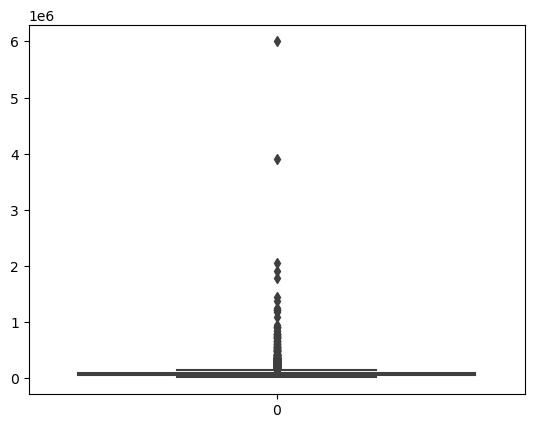

In [21]:
sns.boxplot(loan_df['annual_inc'])

##### Plot Analysis - the box plot shows that there are outliners present in 'annual inc' hence this should be removed from analysis.
##### Considering the 99 percentile value and filtering data using the same.

<Axes: >

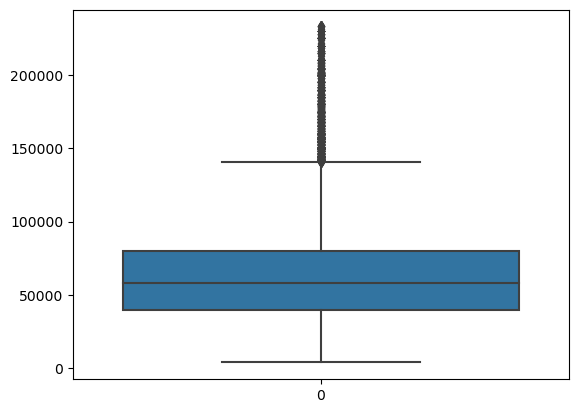

In [22]:
#Remove the records which are greater than 99 percentile
loan_df = loan_df[loan_df.annual_inc<loan_df['annual_inc'].quantile(0.99)]
sns.boxplot(loan_df['annual_inc'])

##### Filter the dataframe based on 'loan_status' as we only need to analyze the 'charged off' record to understand the defaulted loan application

In [23]:
loan_df_default=loan_df[loan_df['loan_status']=='Charged Off']

##### This code analyzes and visualizes loan status distribution in 'Df_loan' using a percentage-based bar plot with improved labels and formatting

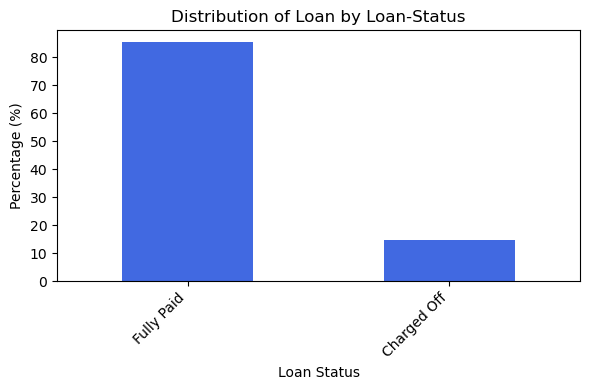

In [24]:
loan_status_per = (loan_df['loan_status'].value_counts() / len(loan_df) * 100).round(2)
plt.figure(figsize=(6, 4))
plt.title('Distribution of Loan by Loan-Status')
plt.xlabel('Loan Status')
plt.ylabel('Percentage (%)')
ax = loan_status_per.plot(kind='bar', color='royalblue')
ax.set_xticklabels(loan_status_per.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Univariate Analysis 

##### This code assesses 'Charged Off' and 'Fully Paid' loans, computing default rates across various verification statuses and rendering them via a bar plot.

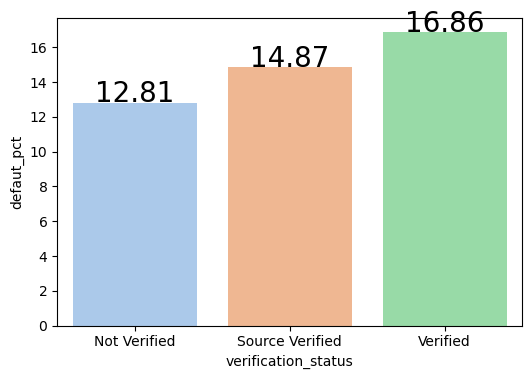

In [25]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('verification_status').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('verification_status').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)
merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='verification_status')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct')


plt.figure(figsize=(6,4))
plots = sns.barplot(data =merged_df,x='verification_status', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:
   
      plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=20, xytext=(0, 6),
                   textcoords='offset points')

plt.show()

## <span style="color:blue">Observation</span>
##### Borrowers with unverified income sources are 16.86% more likely to default on their loans. This suggests a connection between inadequate income verification and a higher risk of loan default. Lenders should consider improving income verification processes to mitigate this risk

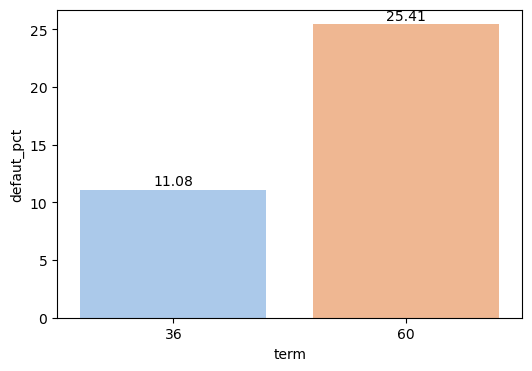

In [26]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('term').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('term').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)

merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='term')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct')


plt.figure(figsize=(6,4))
plots = sns.barplot(data =merged_df,x='term', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:
     plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')

plt.xticks(rotation=360)
plt.show()

## <span style="color:blue">Observation</span>
##### Loans with a 60-month term have the highest default rate at 25.41%.To mitigate this risk, consider offering borrowers with longer-term loans more rigorous income verification processes or requiring additional collateral

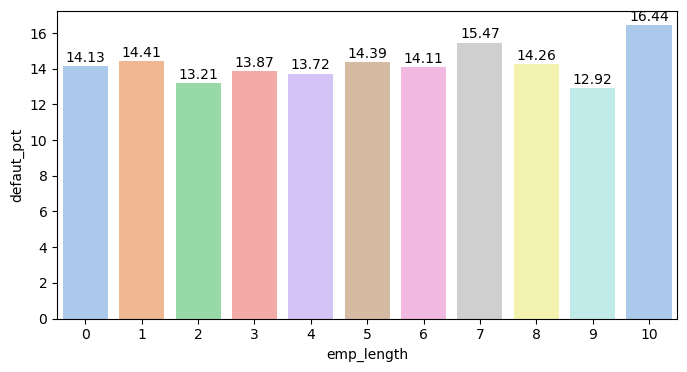

In [27]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('emp_length').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('emp_length').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)


merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='emp_length')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct')


plt.figure(figsize=(8,4))
plots = sns.barplot(data =merged_df,x='emp_length', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')

plt.xticks(rotation=360)
plt.show()

## <span style="color:blue">Observation</span>
##### It is evident that individuals with employment histories of 7 years or more and 10 years or more tend to experience a higher frequency of loan defaults. To address this trend, lenders should consider implementing stricter income verification procedures for borrowers in these categories

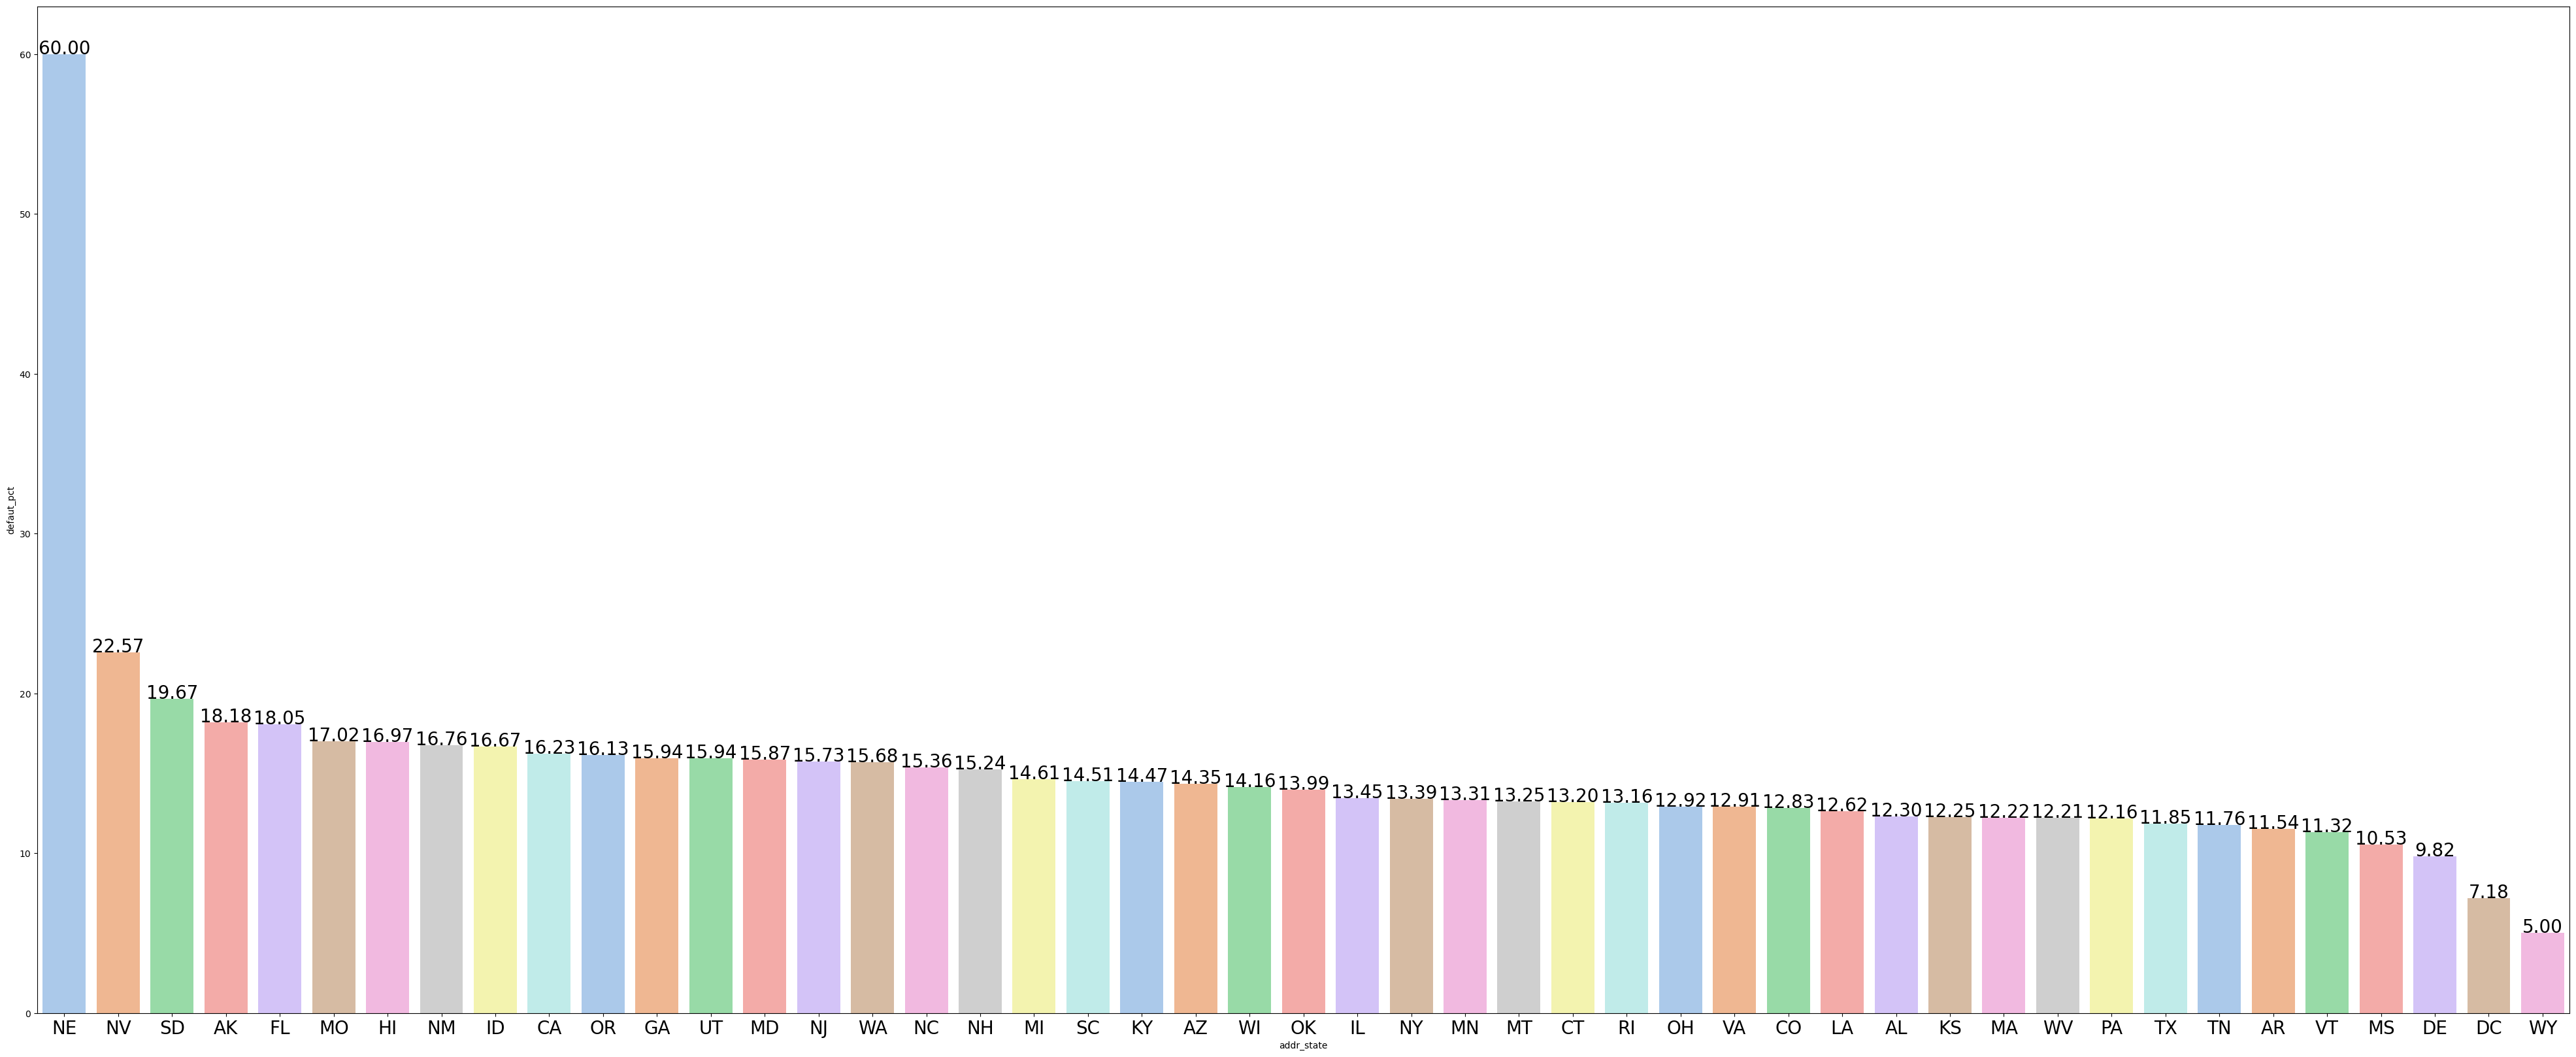

In [28]:
# Summary: This code analyzes loan data based on the borrower's state address, specifically focusing on 'Charged Off' and 'Fully Paid' loans.
# It calculates the default percentage for each state and visualizes the results using a bar plot with enhanced annotations.

loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('addr_state').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('addr_state').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)

merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='addr_state')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct',ascending=False)


plt.figure(figsize=(50,20))
plots =sns.barplot(data =merged_df,x='addr_state', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=20, xytext=(0, 6),
                   textcoords='offset points')

plt.xticks(rotation=360, fontsize=20)
plt.show()

## <span style="color:blue">Observation</span>
##### It's apparent that specific states, notably NE (Nebraska) and NV (Nevada), exhibit a notably elevated occurrence of loan defaults. To address this issue, financial institutions should conduct more comprehensive credit assessments and risk evaluations for borrowers residing in these states.

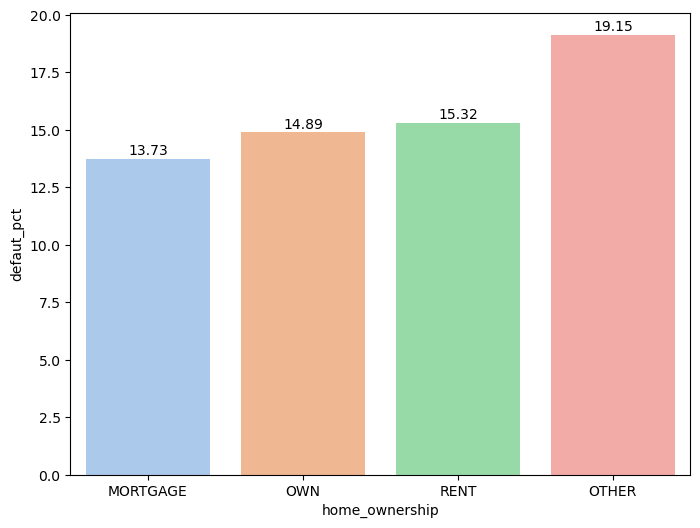

In [29]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('home_ownership').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('home_ownership').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)


merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='home_ownership')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct')
plt.figure(figsize=(8,6))
plots = sns.barplot(data =merged_df,x='home_ownership', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')

plt.show()

## <span style="color:blue">Observation</span>
##### The data indicates that borrowers categorized as either "Rent" or "Mortgage" owners tend to have a higher default count compared to those labeled as 'Other,' although 'Other' has the highest default count. This points to a potential issue with the current loan categorization system, which may not adequately capture the specific nuances of borrower situations. To address this, it's advisable to refine the loan categorization criteria for a more accurate analysis.

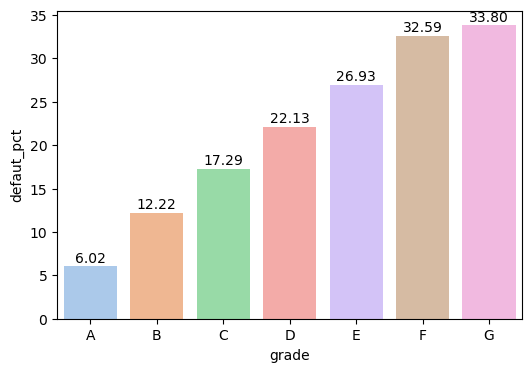

In [30]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('grade').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('grade').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)

merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='grade')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct')
plt.figure(figsize=(6,4))
plots = sns.barplot(data =merged_df,x='grade', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')
plt.show()

## <span style="color:blue">Observation</span>
##### Upon closer examination of the data, it's evident that loans categorized under Grade G have the highest frequency of defaults, while loans labeled as Grade A show the lowest default rates. To address this disparity, lenders should consider revising their lending criteria, potentially imposing stricter eligibility requirements or higher interest rates for borrowers in the Grade G category.

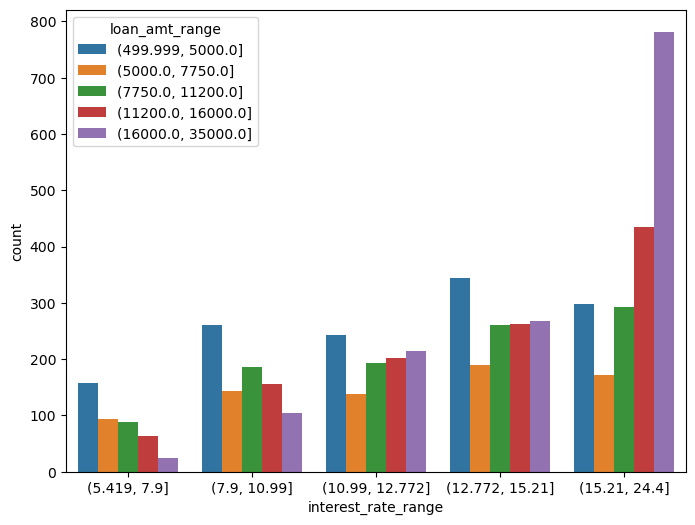

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'interest_rate_range', hue = 'loan_amt_range',data = loan_df[loan_df.loan_status == 'Charged Off'])
plt.show()

## <span style="color:blue">Observation</span>
##### A noticeable trend emerges when examining the data: borrowers who have secured larger loan amounts and are subject to the highest interest rates tend to exhibit a significantly higher rate of defaults. This correlation indicates that there is an inherent risk associated with offering larger loans with high interest rates.

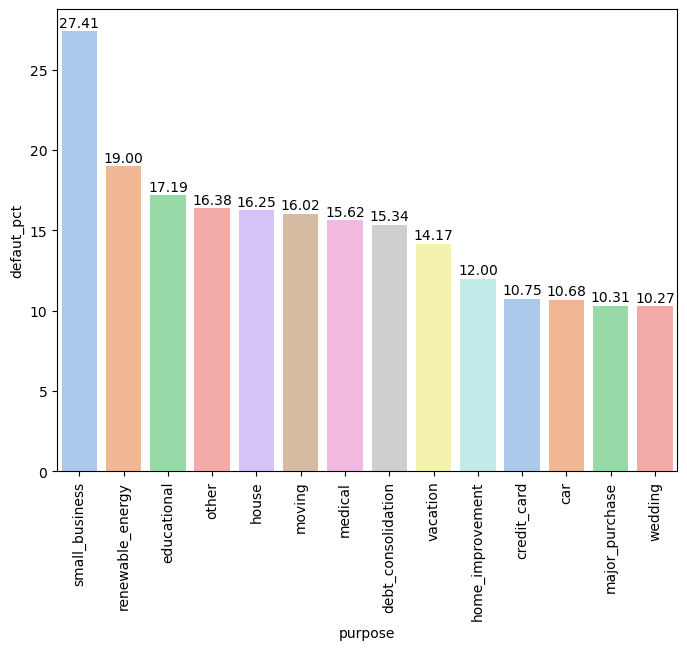

In [32]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('purpose').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('purpose').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)


merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='purpose')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct',ascending=False)
plt.figure(figsize=(8,6))
plots = sns.barplot(data =merged_df,x='purpose', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:
   

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')

plt.xticks(rotation=90)
plt.show()

## <span style="color:blue">Observation</span>
##### **Annual Income and Purpose:** The data highlights a notable pattern in loan purposes and default rates. Loans intended for specific purposes, such as Small Business, Renewable Energy, and Education, consistently show higher default rates. 

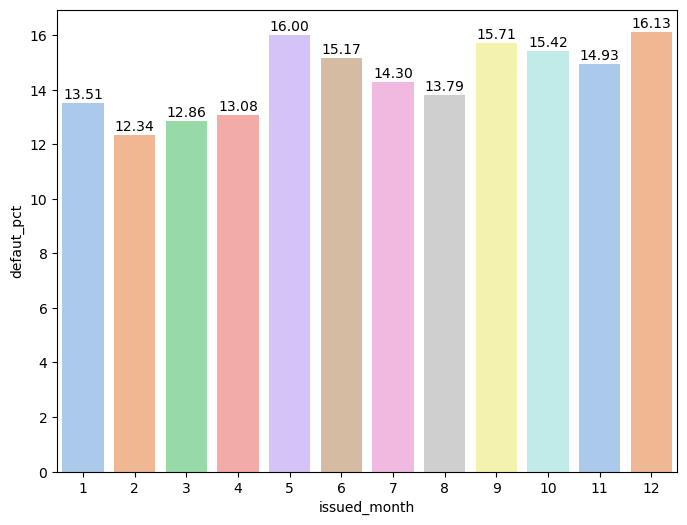

In [33]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('issued_month').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('issued_month').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)


merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='issued_month')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100

merged_df = merged_df.sort_values('defaut_pct')


plt.figure(figsize=(8,6))
plots = sns.barplot(data =merged_df,x='issued_month', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')

plt.xticks(rotation=360)
plt.show()

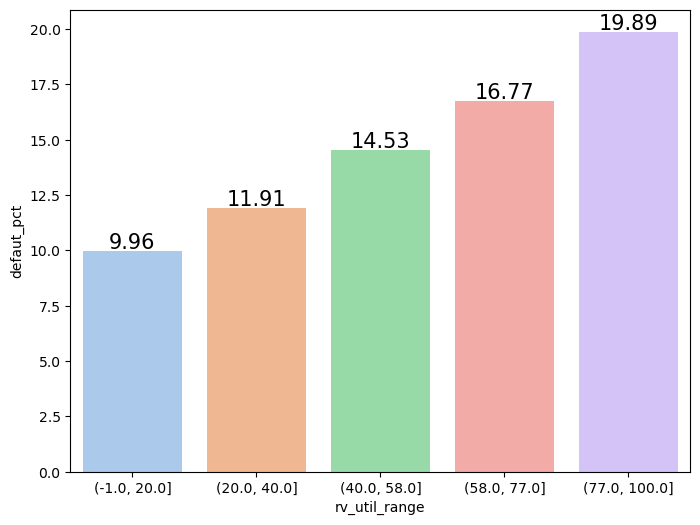

In [34]:
loan_df_chargedOff= loan_df[loan_df.loan_status == 'Charged Off'].groupby('rv_util_range').size().reset_index(name='Charged Count').sort_values(by='Charged Count', ascending=False)
loan_df_fullyPaid= loan_df[loan_df.loan_status == 'Fully Paid'].groupby('rv_util_range').size().reset_index(name='Paid Count').sort_values(by='Paid Count', ascending=False)

merged_df = pd.merge(loan_df_chargedOff, loan_df_fullyPaid, on='rv_util_range')
merged_df["defaut_pct"] =(merged_df["Charged Count"]/(merged_df["Charged Count"]+merged_df["Paid Count"]))*100
merged_df = merged_df.sort_values('defaut_pct')


plt.figure(figsize=(8,6))
plots = sns.barplot(data =merged_df,x='rv_util_range', y='defaut_pct',palette="pastel")

# Iterating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 6),
                   textcoords='offset points')

plt.show()

## <span style="color:blue">Observation</span>
##### An important trend emerges from the data: as the utilization of revolving lines of credit increases, there is a corresponding rise in the rate of loan defaults. This connection suggests a significant link between how borrowers manage their existing credit lines and their likelihood of defaulting on new loans. 

## Segmented Univariate Analysis

### Loan Amount

<Axes: title={'center': 'Grade vs Loan Amount'}, xlabel='grade', ylabel='loan_amnt'>

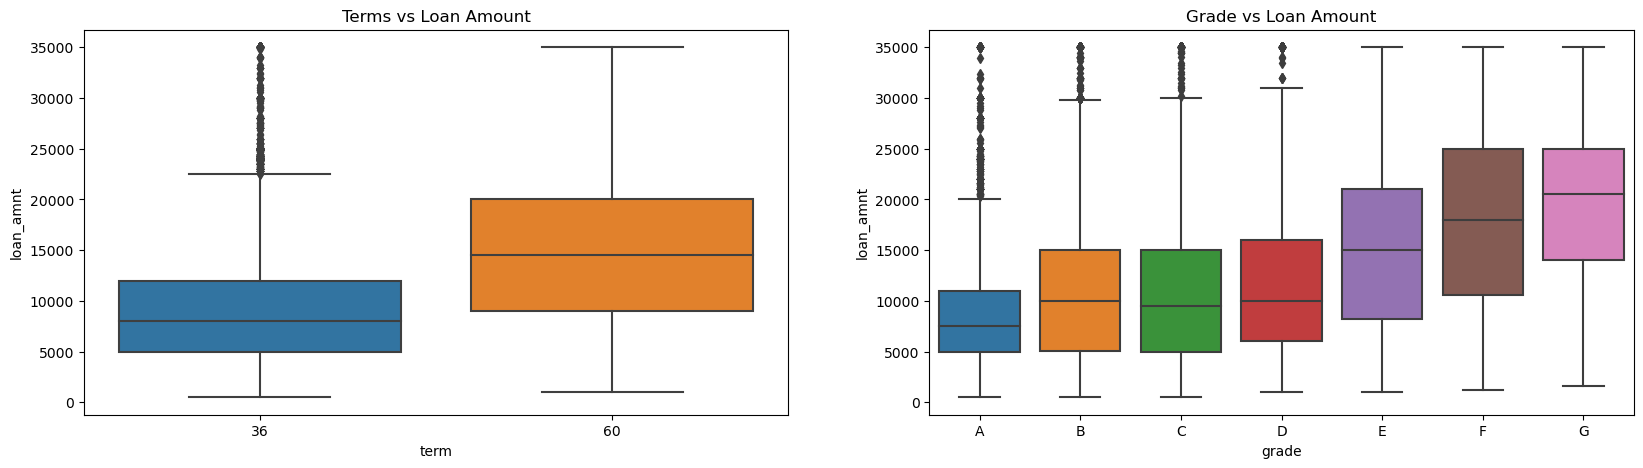

In [35]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.boxplot(x='term', y=loan_df.loan_amnt, data=loan_df)
plt.title('Terms vs Loan Amount')
plt.subplot(122)
plt.title('Grade vs Loan Amount')
#Finding grades with sorted alphabetical order
grade_ord = loan_df.grade.unique()
grade_ord.sort()
sns.boxplot(x='grade', y=loan_df.loan_amnt, order = grade_ord, data=loan_df)

## <span style="color:blue">Observation</span>
Higher amount loans have high tenure i.e, 60 months.  
Grade 'G' and 'H' have taken max loan amount. As Grades are decreasing the loan amount is increasing.

<Axes: title={'center': 'verification_status vs Loan Amount'}, xlabel='verification_status', ylabel='loan_amnt'>

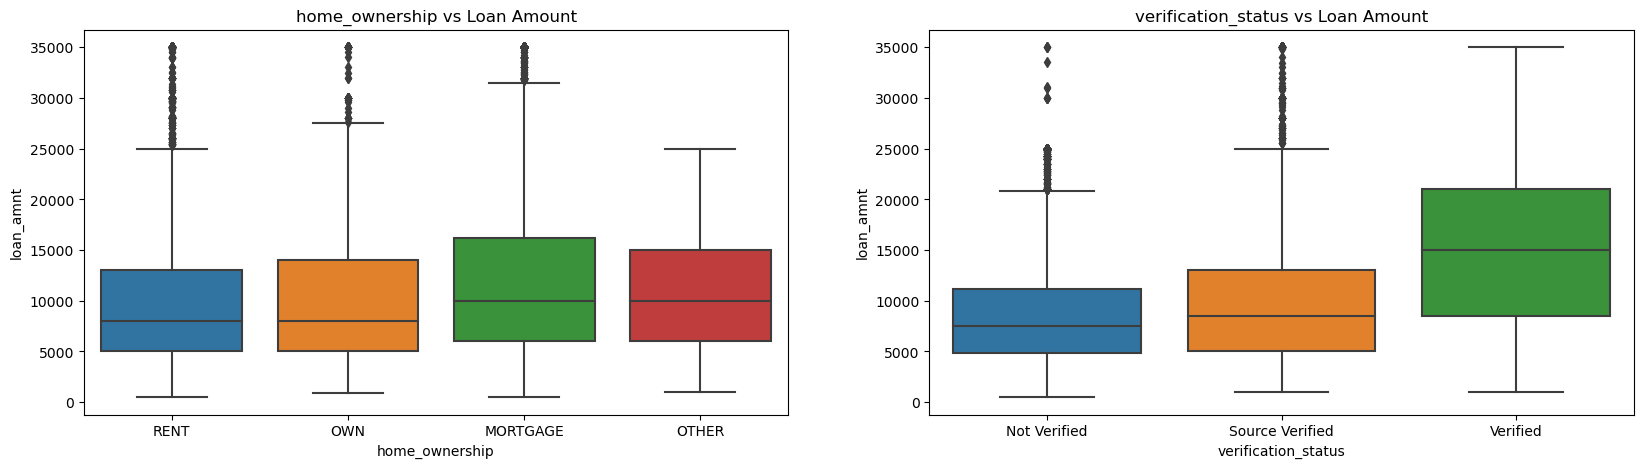

In [36]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.boxplot(x='home_ownership', y=loan_df.loan_amnt, data=loan_df)
plt.title('home_ownership vs Loan Amount')
plt.subplot(122)
plt.title('verification_status vs Loan Amount')
verification_status_ord = loan_df.verification_status.unique()
verification_status_ord.sort()
sns.boxplot(x='verification_status', y=loan_df.loan_amnt, order = verification_status_ord, data=loan_df)

## <span style="color:blue">Observation</span>
more borrowers are from MORTAGE and also the median loan amount also high for MORTAGE owned borrowers.  
And most of borrowers are verified for borrowing loan >9k

<Axes: title={'center': 'Grade vs dti'}, xlabel='grade', ylabel='dti'>

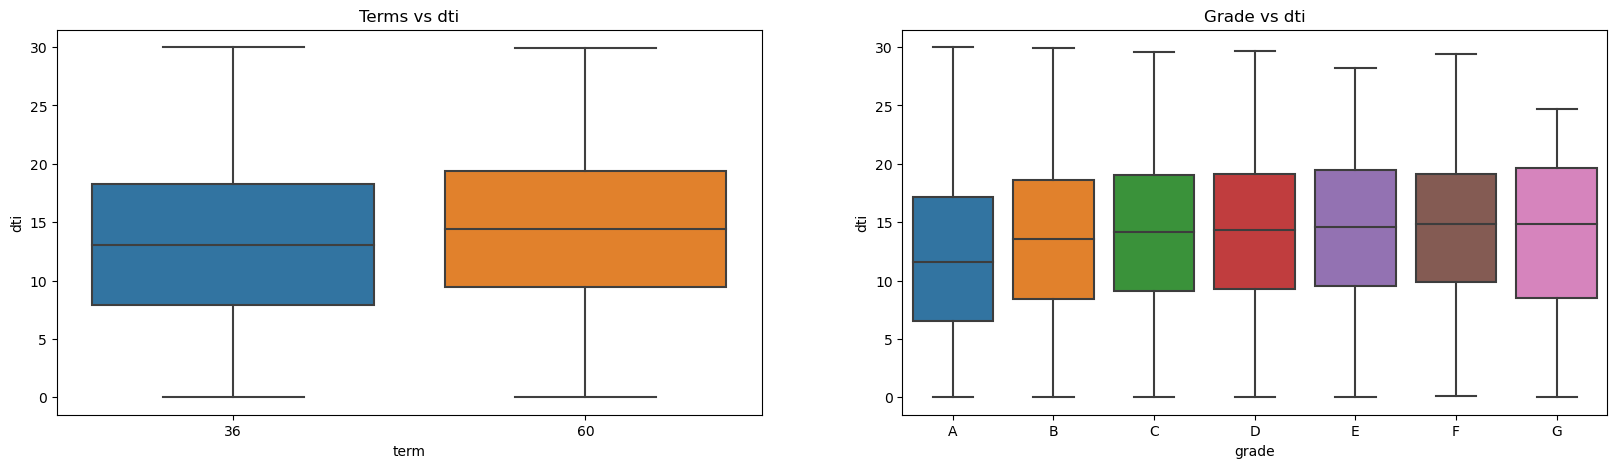

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.boxplot(x='term', y=loan_df.dti, data=loan_df)
plt.title('Terms vs dti')
plt.subplot(122)
plt.title('Grade vs dti')
grade_ord = loan_df.grade.unique()
grade_ord.sort()
sns.boxplot(x='grade', y=loan_df.dti, order = grade_ord, data=loan_df)

## <span style="color:blue">Observation</span>  
DTI is bit high for people who got more tenure i.e., 60 months.  
A Grade barrowers are having low DTI than Other grades. DTI should be low for having high repayment percentage.

## Bivariate Analysis ##

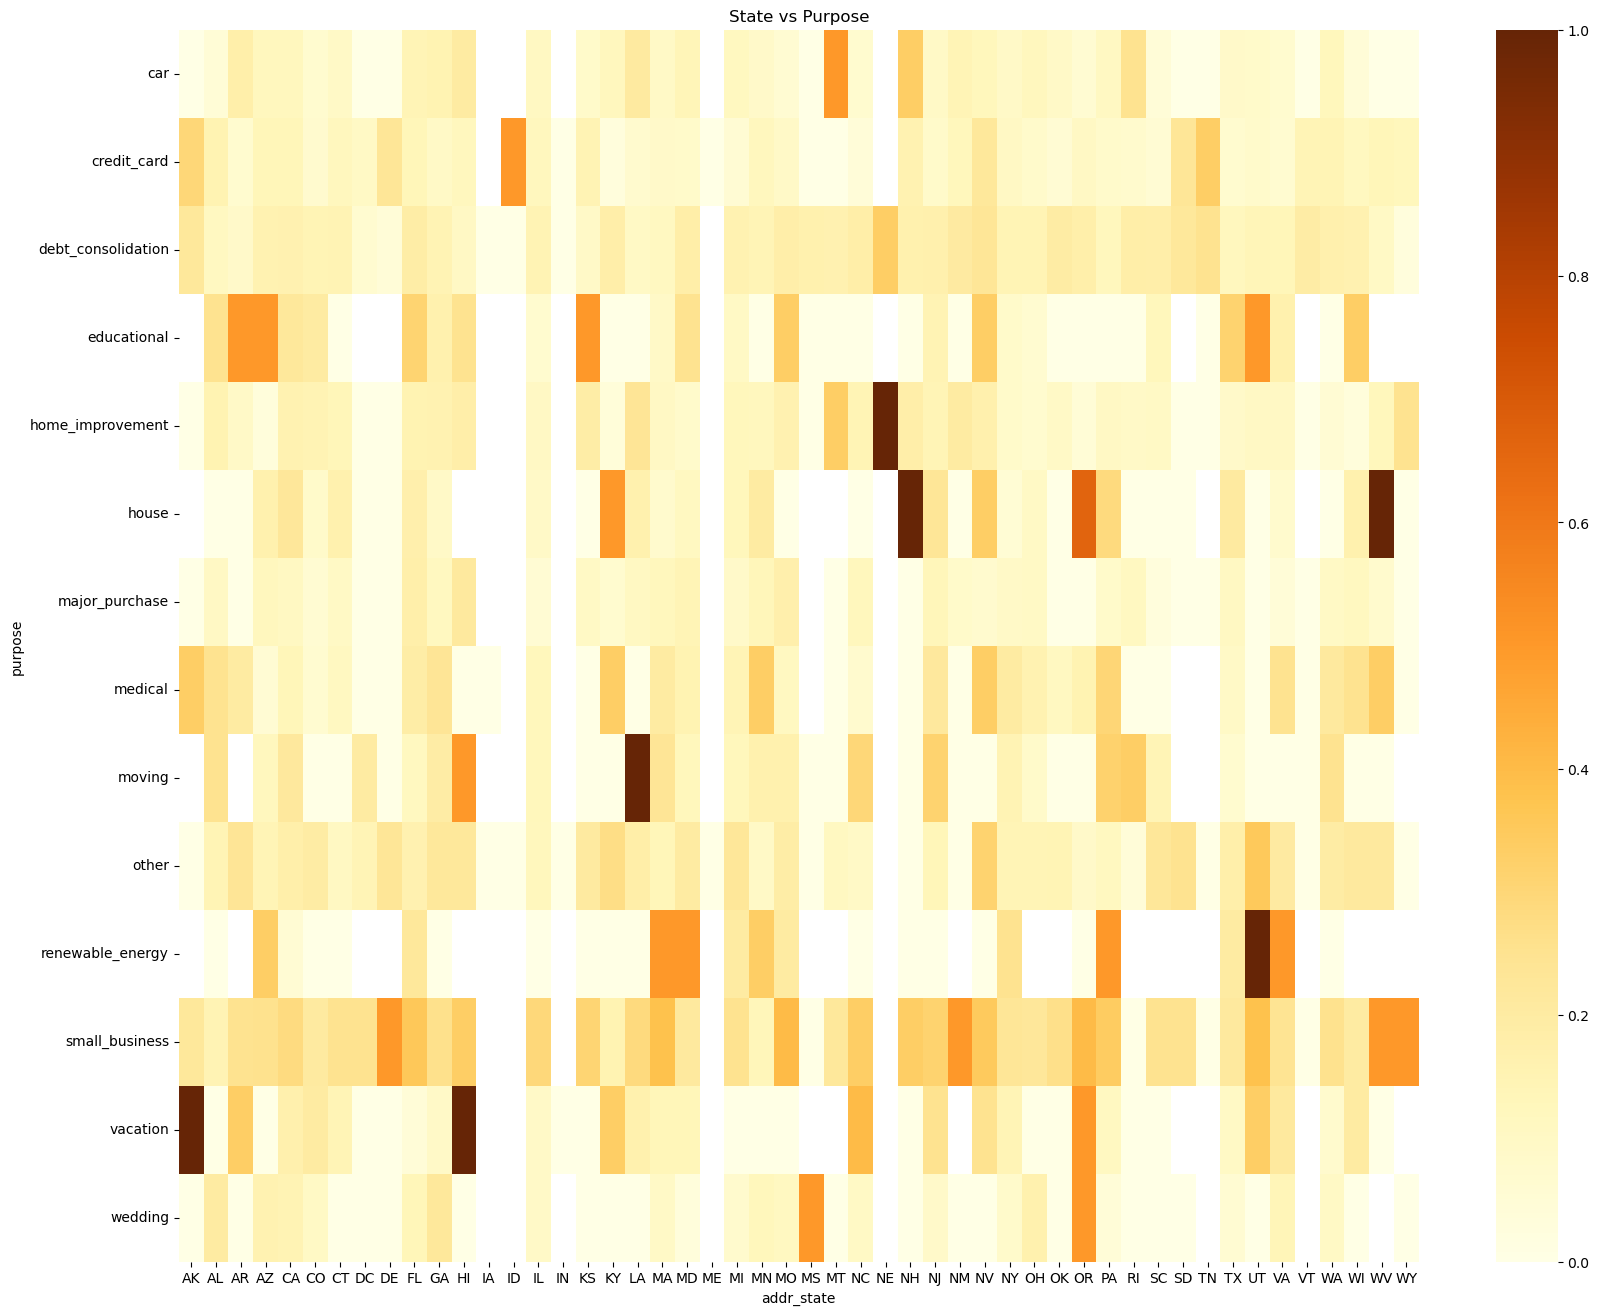

In [38]:
loan_df['loan_status_index'] = loan_dataframe['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)
fig, ax = plt.subplots(figsize=(20,16))
pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='purpose', columns='addr_state')

sns.heatmap(pivot_table, annot=False, cmap='YlOrBr', fmt=".2f")
plt.title('State vs Purpose')
plt.show()

## <span style="color:blue">Observation</span>
##### **State-wise Loan Default Trends and Suggestions (Concise):**

- **AK and HI (Alaska and Hawaii) for Vacation Loans:** Implement stricter eligibility criteria and financial education for vacation loans to address seasonal income challenges.

- **UT (Utah) for Renewable Energy Loans:** Offer more flexible financing options for renewable energy projects to make them more affordable and reduce defaults.

- **LA (Louisiana) for Moving Loans:** Assess employment stability and consider providing financial counseling to help manage moving expenses effectively.

- **NH (New Hampshire) & WV (West Virginia) for Home Loans and NE (New Hampshire) for Home Improvement:** Conduct thorough credit assessments and offer specialized loan products, like down payment assistance, to address economic challenges and improve home loan repayment rates. 

By tailoring lending practices and providing financial education, lenders can address the specific issues contributing to higher default rates in these states and loan categories.. 

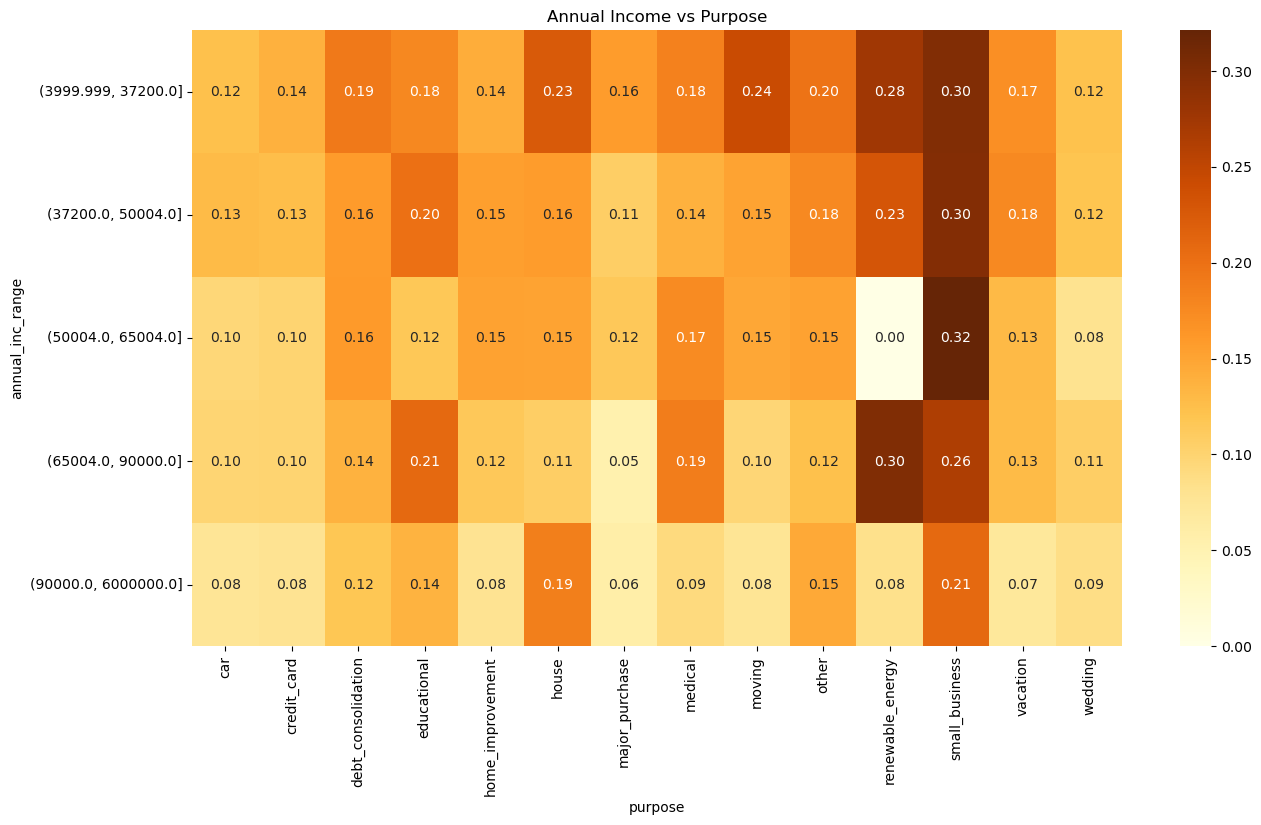

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='annual_inc_range', columns='purpose')

sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")

# Rotate the x and y axis labels
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title('Annual Income vs Purpose')
plt.show()

## <span style="color:blue">Observation</span>
##### 
1. **Loan Purpose and Defaults:** Small Business and Renewable Energy loans exhibit higher default rates.

2. **Small Business Loans (0-65K Income):** Borrowers in this income range have a higher Small Business loan default rate, indicating potential challenges in entrepreneurship.

3. **Moving and Housing Loans (4-37K Income):** These loans face increased defaults among lower-income borrowers, suggesting financial strain related to relocation and housing expenses.

4. **Renewable Energy Loans (65-90K Income):** Borrowers with incomes of 65K to 90K experience higher defaults in Renewable Energy loans, possibly due to project affordability.



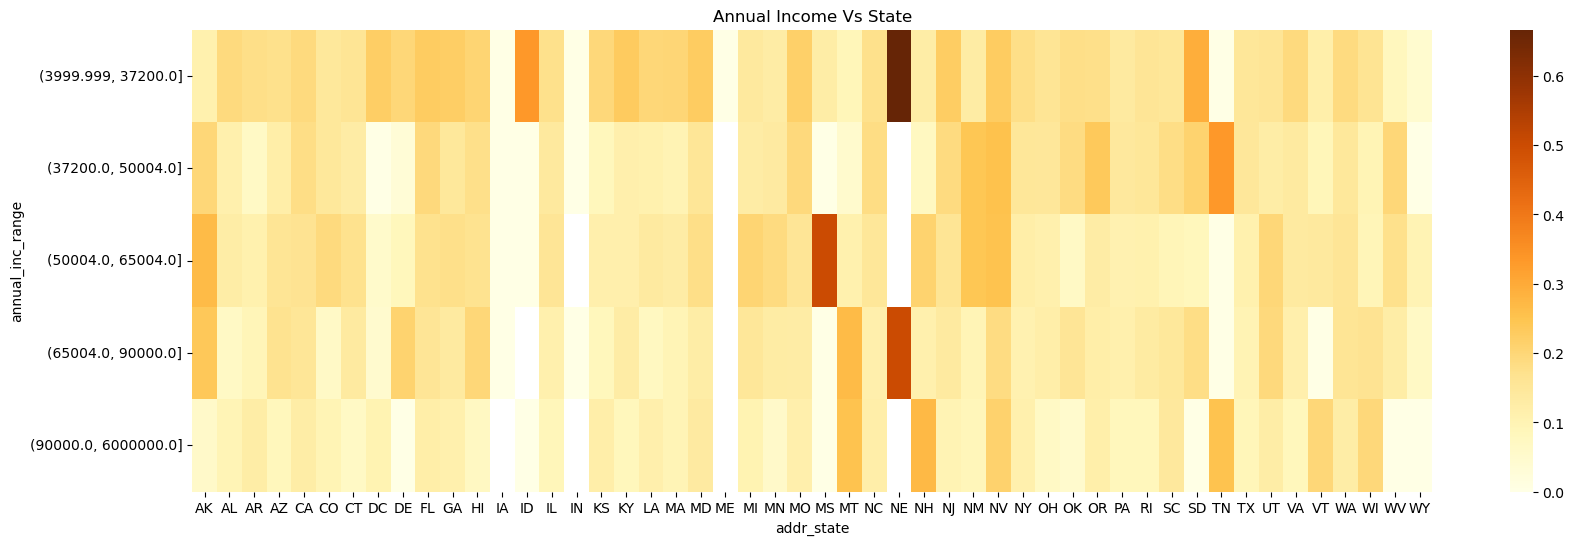

In [40]:
# Summary: This code creates a heatmap visualization to explore the relationship between annual income,
# state of residence, and loan status index using a pivot table from the provided loan data.
# It helps visualize how annual income and state correlate with loan status.

fig, ax = plt.subplots(figsize=(20,6))

pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='annual_inc_range', columns='addr_state')

sns.heatmap(pivot_table, annot=False, cmap='YlOrBr', fmt=".2f")
#sns.heatmap(pivot_table, ax=ax)
plt.title('Annual Income Vs State')
plt.xticks(rotation=360)
plt.yticks(rotation=0)
plt.show()

## <span style="color:blue">Observation</span>
##### 
**State-wise Default Trends and Suggestions:**

1. **Mississippi (MS) (50-65K Income Range):** A noticeable trend is the higher rate of defaults in Mississippi for borrowers with incomes between 50K to 65K. To address this, lenders can consider offering financial education programs and more tailored loan products to help borrowers in this income bracket manage their finances better and reduce default risks.

2. **Idaho (ID) and Nebraska (NE) (4-37K Income Range):** Idaho and Nebraska exhibit elevated default rates among borrowers with incomes ranging from 4K to 37K. Lenders should conduct thorough income verification processes for these borrowers and potentially offer lower-interest loans or financial counseling to support them in managing their financial obligations more effectively.

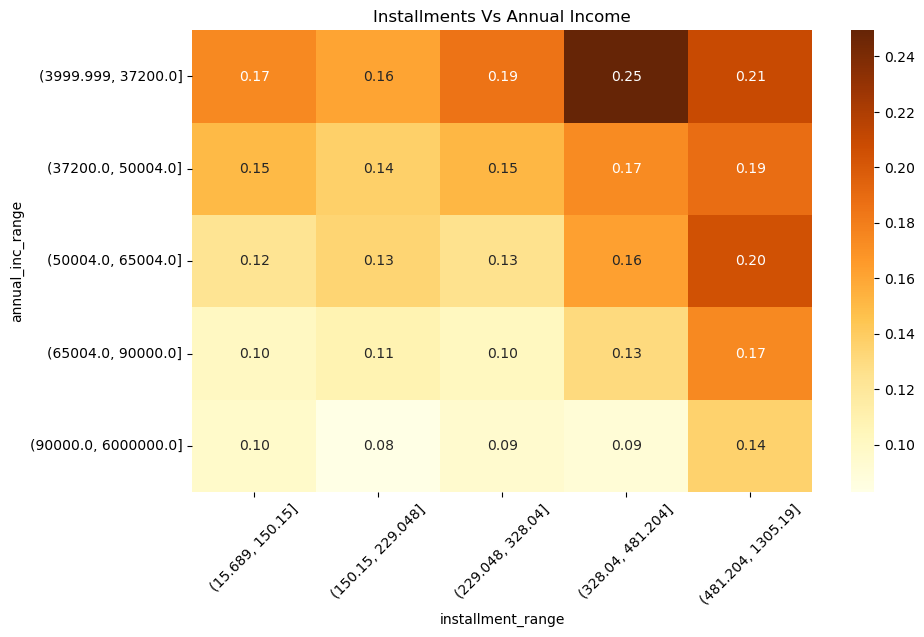

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
#pt = pd.pivot_table(data=Df_loan, values='loan_status', index='purpose', columns='home_ownership')
pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='annual_inc_range', columns='installment_range')

sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")
#sns.heatmap(pivot_table, ax=ax)
plt.title('Installments Vs Annual Income')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## <span style="color:blue">Observation</span>
#####  Higher annual income correlates with lower default rates, indicating greater repayment capacity for borrowers with higher incomes.

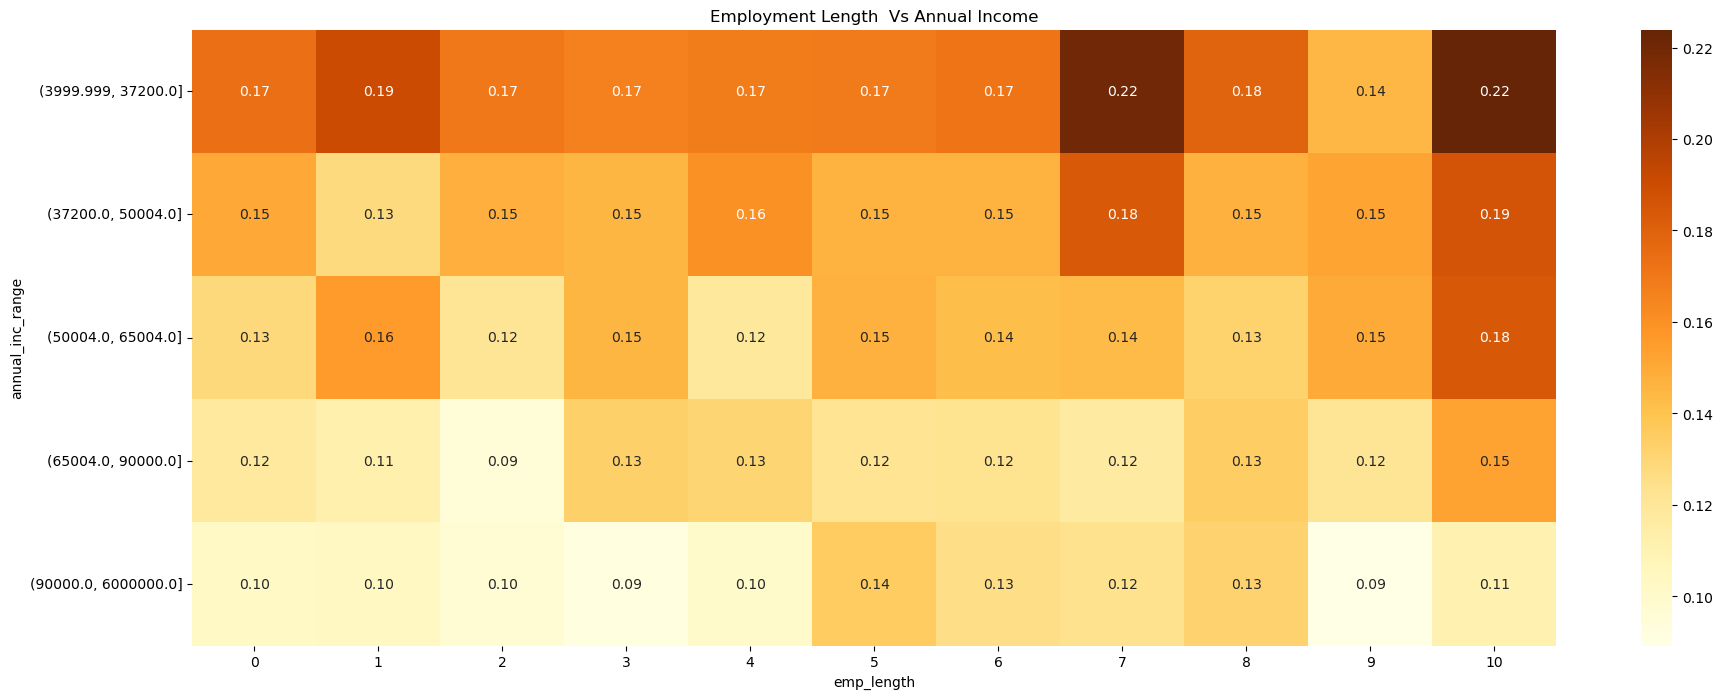

In [42]:
# Summary: This code creates a heatmap to visualize the relationship between 'annual_inc_groups' (annual income groups)
# and 'emp_length' (employment length) in the loan dataset. It uses a pivot table to aggregate and display the data,
# and annotates the heatmap with numeric values. The colormap used is 'Blues', and the title of the plot is set to
# 'Installments Vs Annual Income'.

fig, ax = plt.subplots(figsize=(22,8))

pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='annual_inc_range', columns='emp_length')



sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")

plt.title('Employment Length  Vs Annual Income')
plt.show()


## <span style="color:blue">Observation</span>
#####  When analyzing the relationship between installment payments and annual income, a clear trend emerges: as annual income increases, the default ratio decreases.
This trend suggests that individuals with higher incomes have a greater capacity and affordability to secure and successfully repay loans.

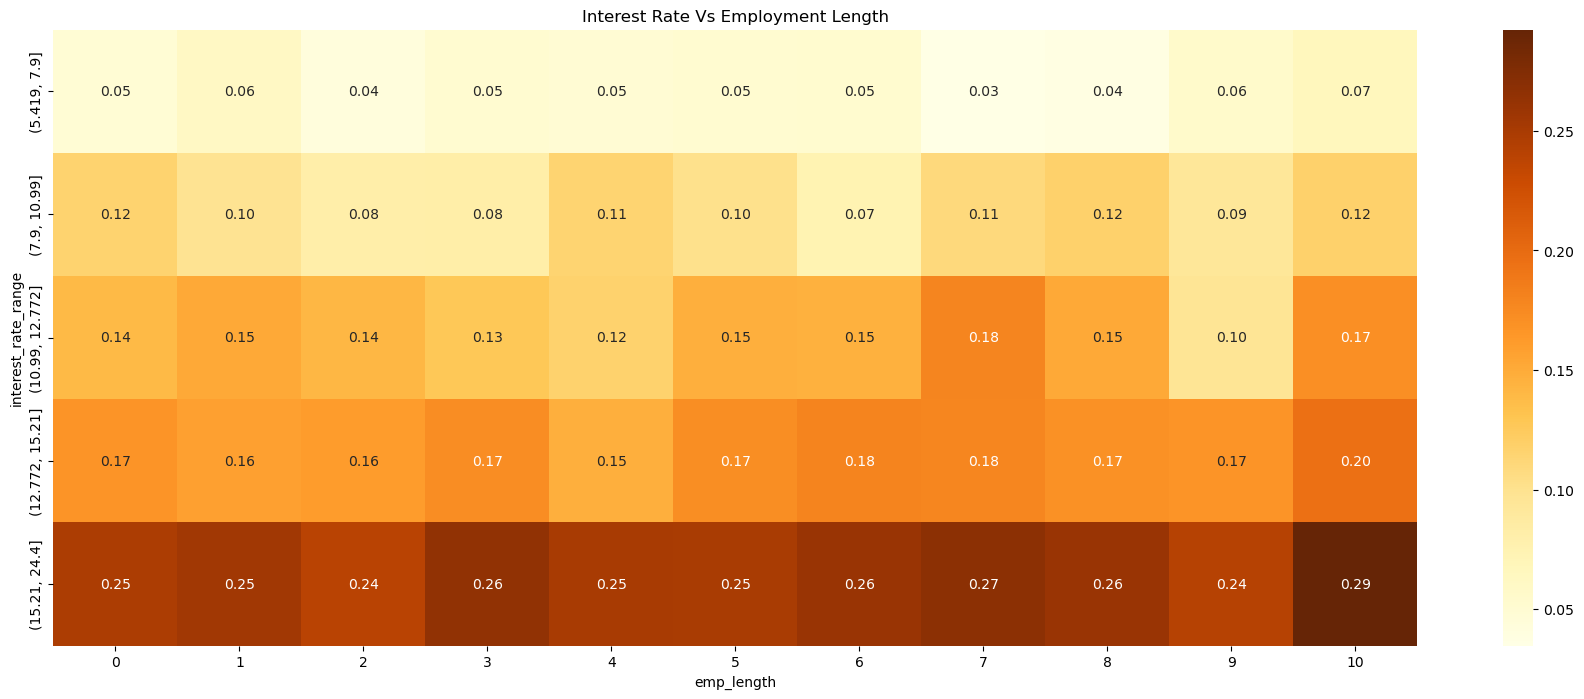

In [43]:
# Summary: This code creates a heatmap to visualize the relationship between interest rates,
# employment length, and loan status by utilizing a pivot table and the Seaborn library.
# It provides insights into how interest rates are distributed across different employment lengths.

fig, ax = plt.subplots(figsize=(22,8))

pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='interest_rate_range', columns='emp_length')

 

sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")

plt.title('Interest Rate Vs Employment Length')
plt.show()

## <span style="color:blue">Observation</span>
#####  We can observe that borrowers with employment lengths of 10+ years and interest rates between 15-24% exhibit the highest number of defaults.

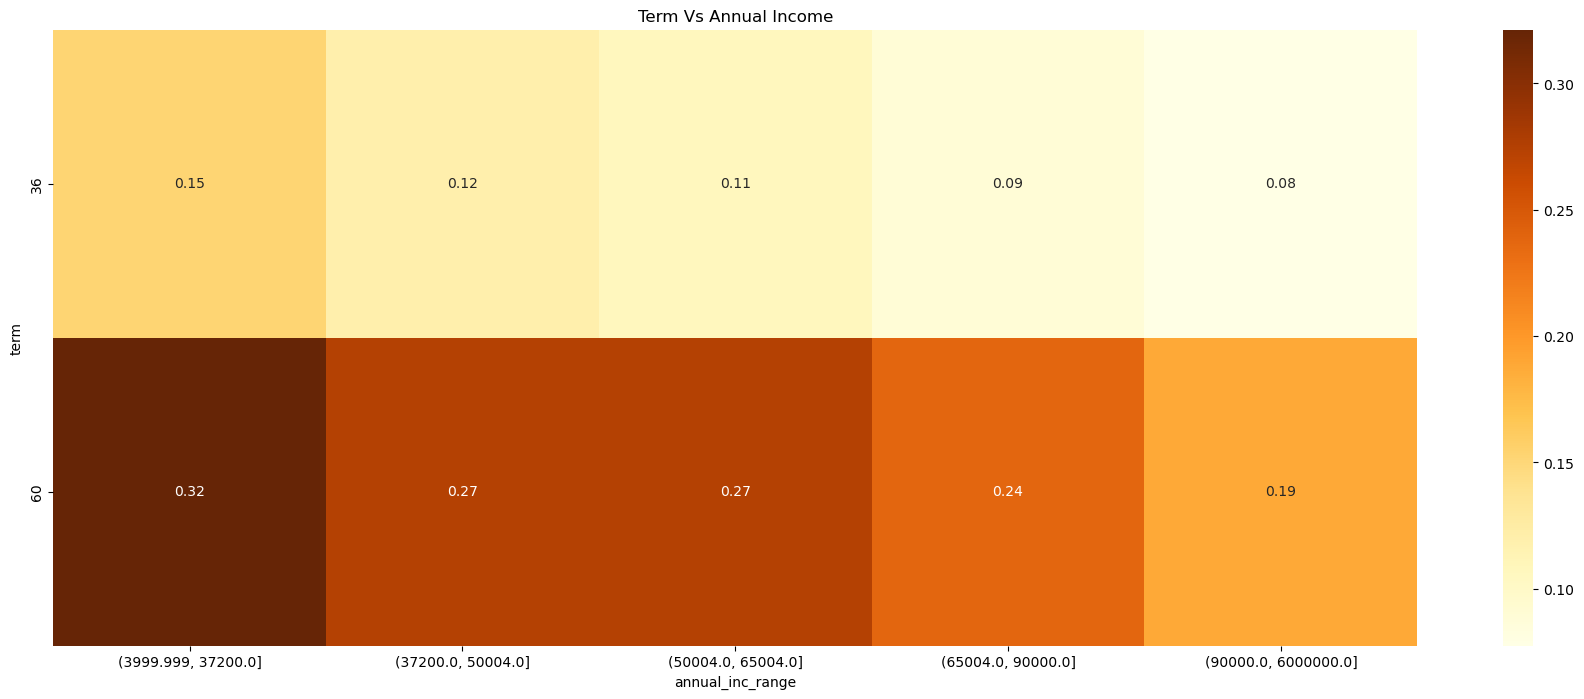

In [44]:
fig, ax = plt.subplots(figsize=(22,8))

pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='term', columns='annual_inc_range')

 

sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")

plt.title('Term Vs Annual Income')
plt.show()

## <span style="color:blue">Observation</span>
#####  This analysis indicates that loans with a 60-month term have the highest number of defaults when annual income falls within the range of 40k.

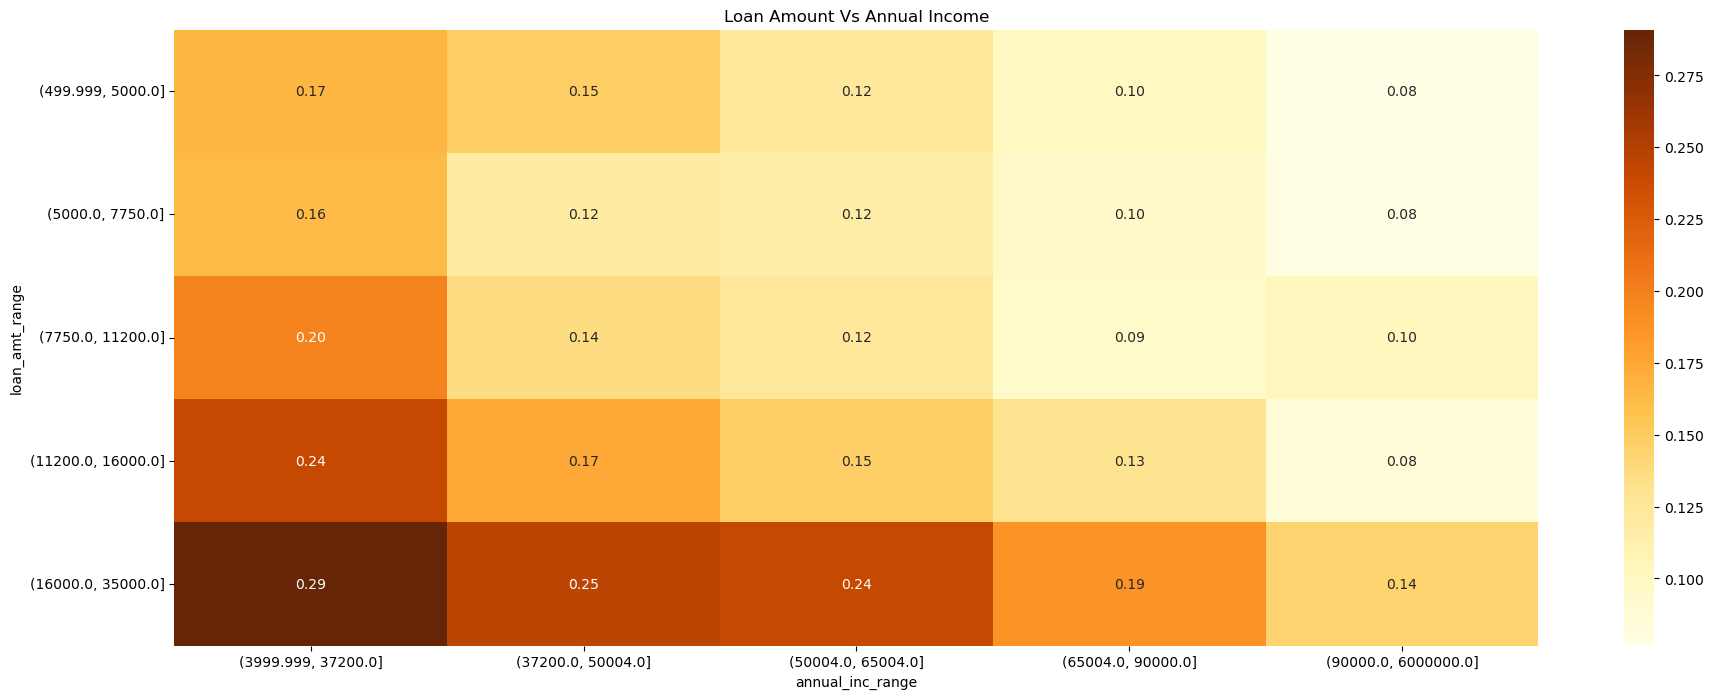

In [45]:
fig, ax = plt.subplots(figsize=(22,8))
#pt = pd.pivot_table(data=Df_loan, values='loan_status', index='purpose', columns='home_ownership')
pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='loan_amt_range', columns='annual_inc_range')

 

sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")
#sns.heatmap(pivot_table, ax=ax)
plt.title('Loan Amount Vs Annual Income')
plt.show()

## <span style="color:blue">Observation</span>
#####  We observed that when the loan amount is between 16k to 35k and annual income is around 40k, borrowers tend to default the most. However, as income increases, the default ratio decreases.

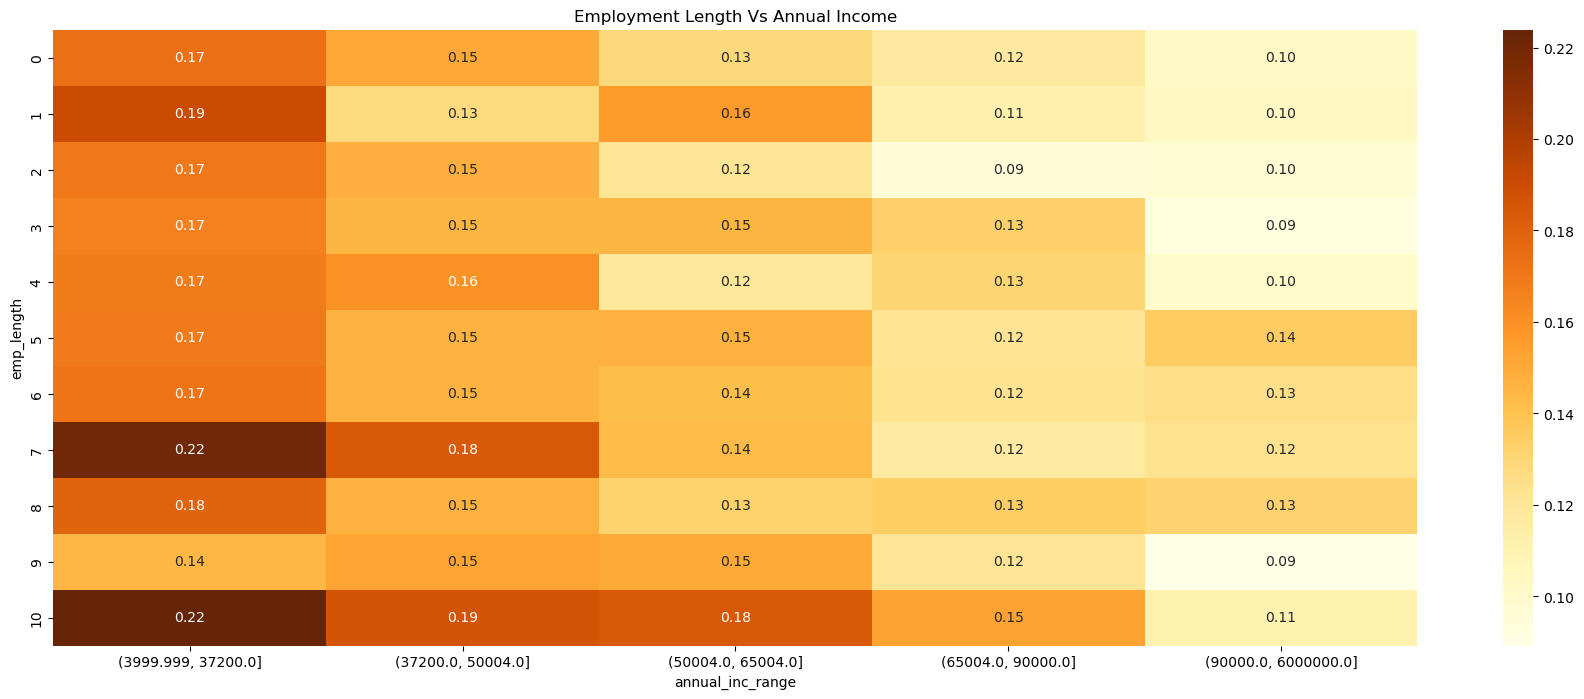

In [46]:
fig, ax = plt.subplots(figsize=(22,8))
#pt = pd.pivot_table(data=Df_loan, values='loan_status', index='purpose', columns='home_ownership')
pivot_table = pd.pivot_table(loan_df, values='loan_status_index', index='emp_length', columns='annual_inc_range')

 

sns.heatmap(pivot_table, annot=True, cmap='YlOrBr', fmt=".2f")
#sns.heatmap(pivot_table, ax=ax)
plt.title('Employment Length Vs Annual Income')
plt.show()

## <span style="color:blue">Observation</span>
#####  We can observe that when annual income is around 40k, individuals with employment lengths between 7 and 10 years have the highest default rate.

## Correlation Analysis
- we perform a correlation analysis to understand the relationships between different parameters in our dataset.
- We visualize the correlations using a clustermap, which helps identify patterns and clusters of related variables

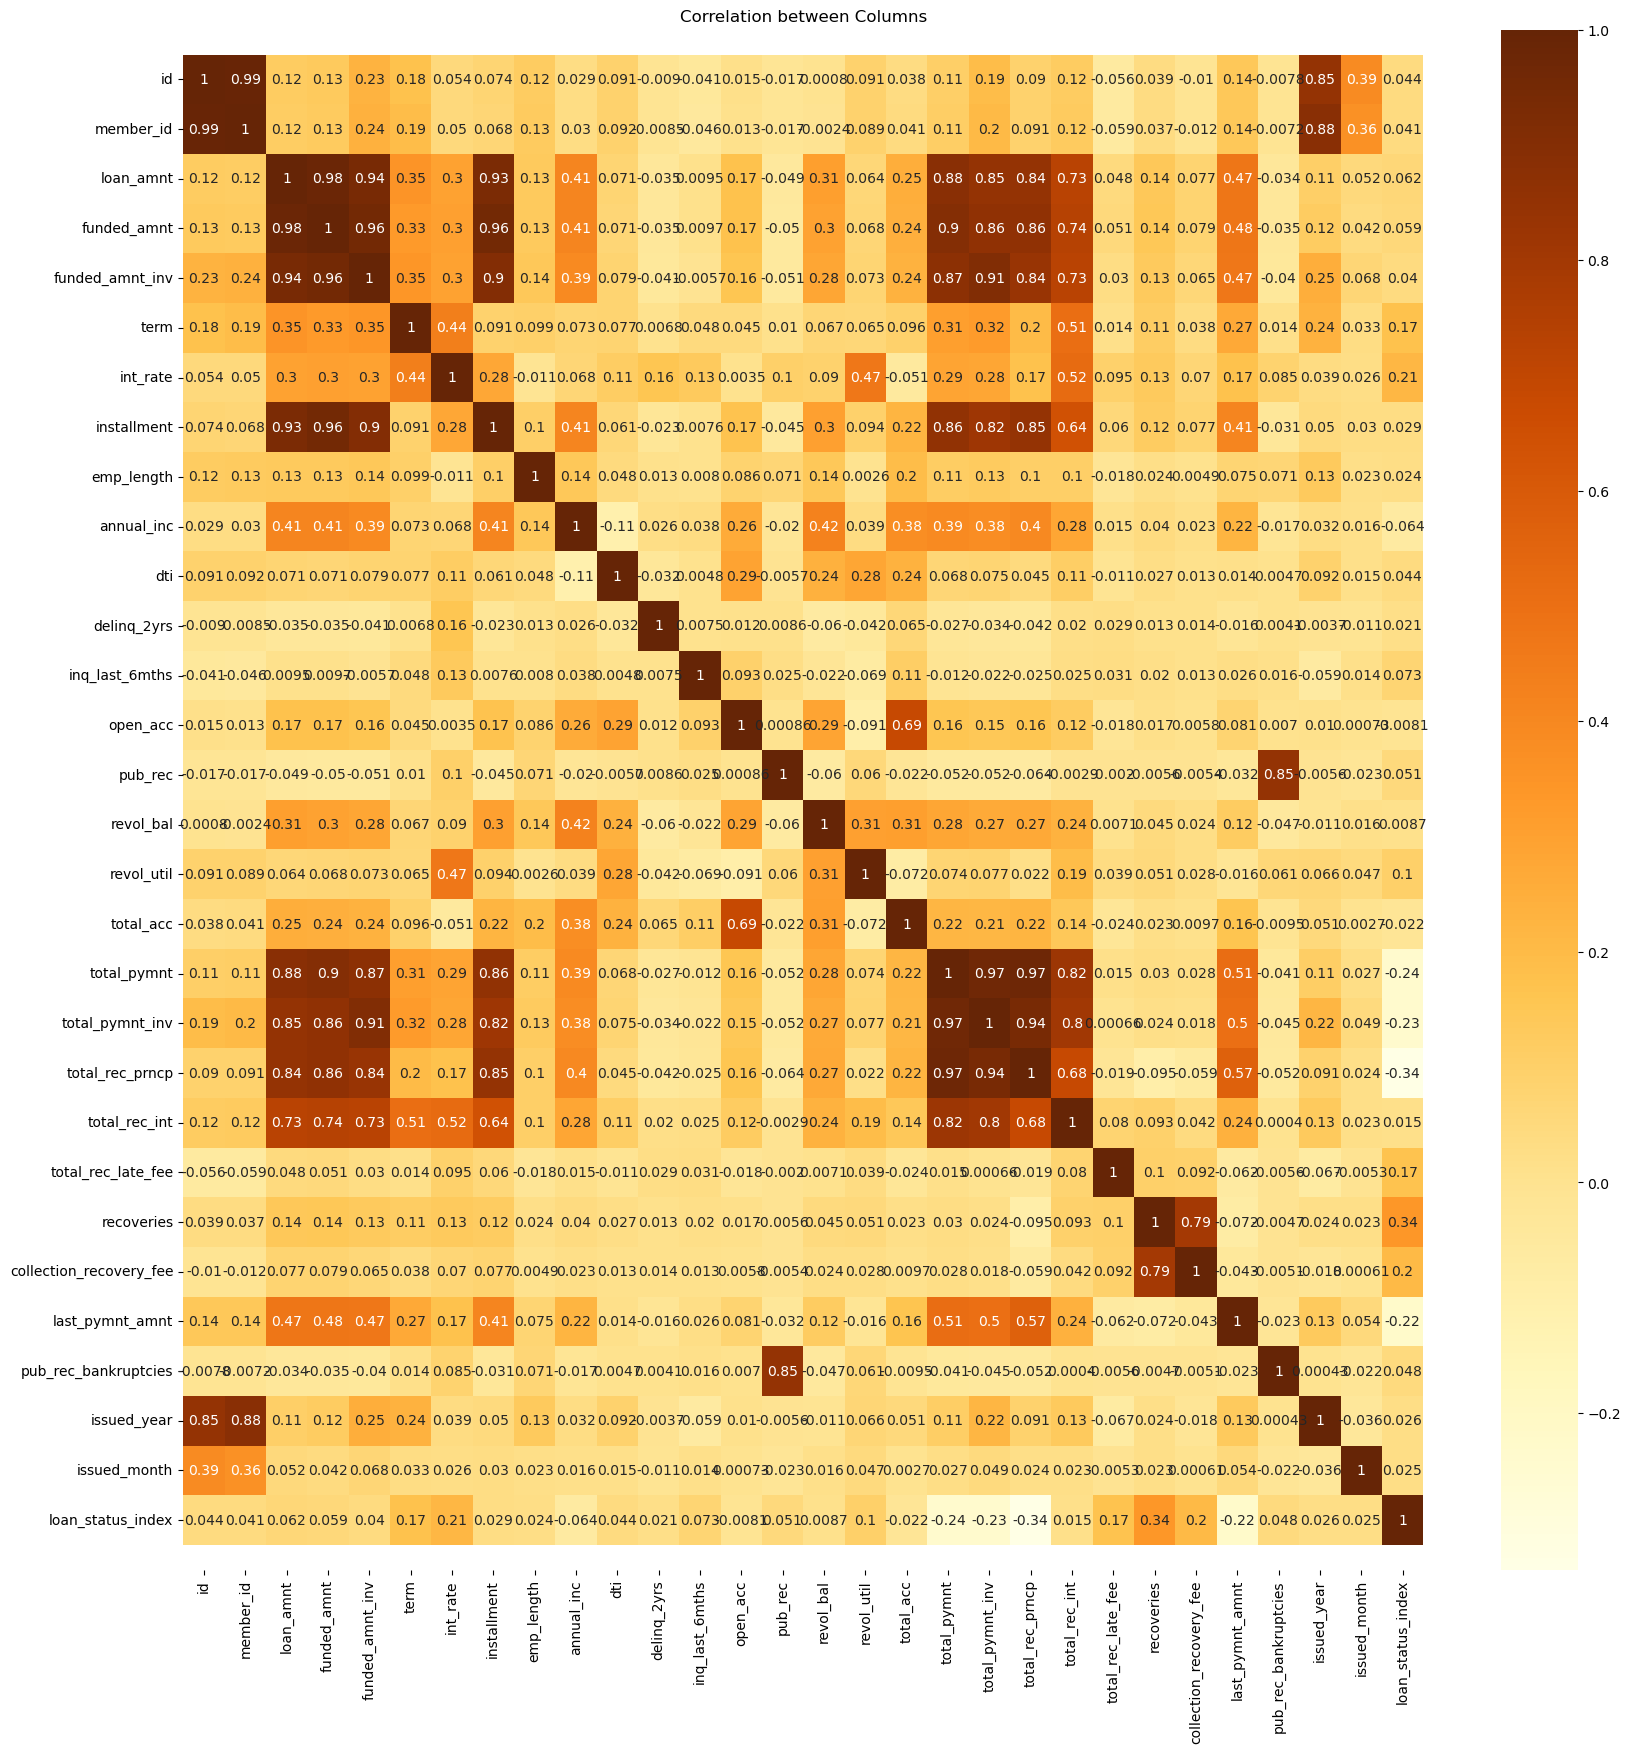

In [48]:
loan_df = loan_df.drop(['out_prncp','out_prncp_inv',],axis=1)
#Finding correlation matric
corr_matrix = loan_df.corr()
plt.figure(figsize=(20,20))
#plotting correlatioon matric on a heat map
ax = sns.heatmap(corr_matrix, annot = True, cmap='YlOrBr')
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)
plt.title("Correlation between Columns")
plt.show()

## <span style="color:blue">Observation</span>  
* Interest rates are high for people with high revol utilisation.